# 신경망 모델 훈련

In [2]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 손실 곡선

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

# 데이터 로드
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()       # 주의: 데이터셋마다 불러오는 함수가 다르다

# 정규화
train_scaled = train_input / 255.0

# 검증 세트 split
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [4]:
######## 모델을 만드는 함수 정의 ########

def model_fn(a_layer=None):                                     # 은닉층 없는 것이 기본값
    model = keras.Sequential()                                  # 빈 모델 생성
    model.add(keras.layers.Flatten(input_shape=(28, 28)))       # flatten 레이어 추가
    model.add(keras.layers.Dense(100, activation='relu'))       # 입력 레이어 추가
    if a_layer:                                                 # 매개변수로 은닉 레이어가 들어왔다면
        model.add(a_layer)                                          # 은닉 레이어 추가
    model.add(keras.layers.Dense(10, activation='softmax'))     # 마지막 출력 레이어 추가
    return model

In [5]:
model = model_fn()          # model 변수에 모델함수 적용

model.summary()             # summary 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [6]:
# 모델 훈련 전 compile
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

# 모델 훈련 시킨 결과를 history 변수에 저장
# verbose = 0 :  훈련 과정을 출력하지 않음
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)        

In [7]:
print(history.history.keys())       # history 변수 안에 'history' 딕셔너리가 저장된다.
# 딕셔너리의 key 값을 확인하려면 '딕셔너리명'.keys()

dict_keys(['loss', 'accuracy'])


In [8]:
print(history.history['loss'])      # 손실값 확인

[0.5311374068260193, 0.3908096253871918, 0.35382795333862305, 0.32939958572387695, 0.3149791955947876]


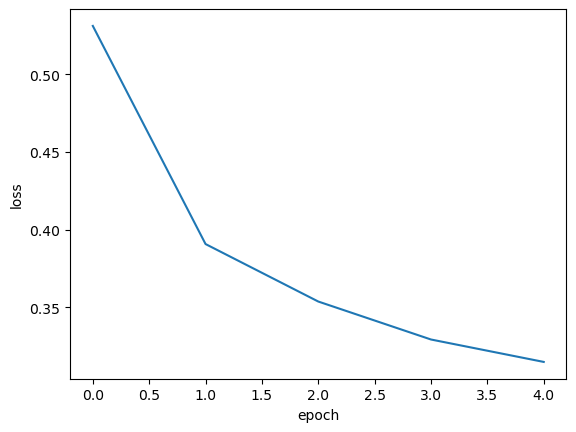

In [9]:
# 손실값을 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
print(history.history['accuracy'])  # 정확도 확인

[0.8112499713897705, 0.8596458435058594, 0.8720208406448364, 0.8823333382606506, 0.8868125081062317]


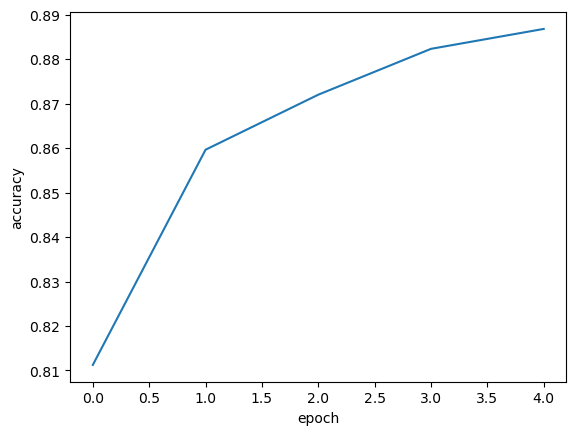

In [11]:
# 정확도를 시각화
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

에포크가 지날 때마다 손실이 감소하고 정확도가 향상되는 것을 확인할 수 있다.   
에포크를 20으로 늘려서 모델을 훈련시켜보자.

In [12]:
# 빈 모델 다시 생성
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

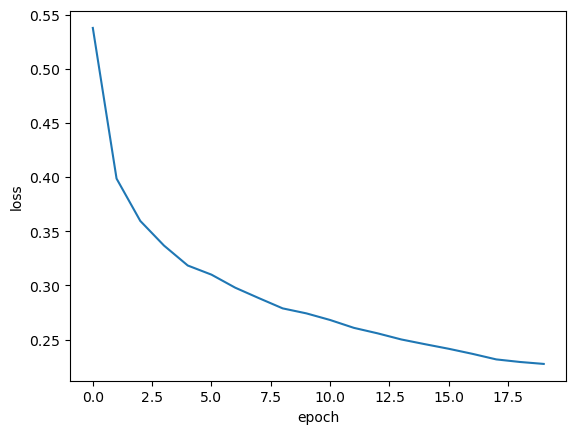

In [13]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

손실이 잘 감소했다. 그런데 더 나은 모델일까?

## 검증 손실

<과대적합을 막기 위한 첫번째 방식>   

에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐 아니라 **검증 세트에 대한 점수도 필요**   
4장에서는 정확도를 사용하여 과대/과소 적합을 설명했지만,   
여기서는 <u>**손실**을 사용하여 과대/과소 적합을 다룬다.</u>

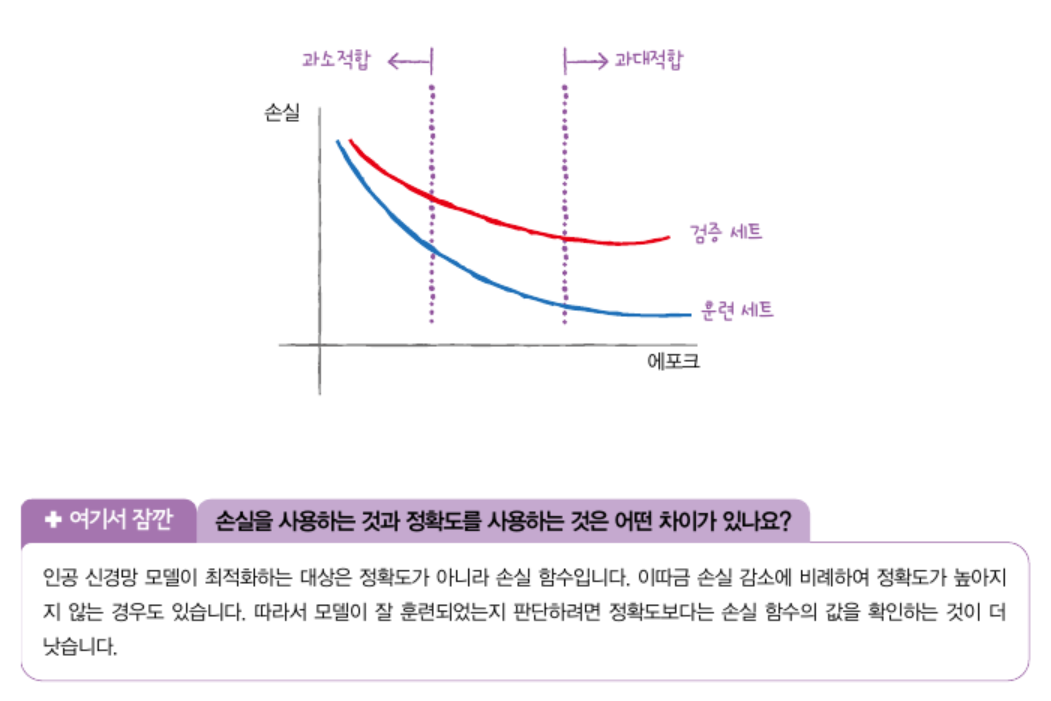

In [14]:
# 검증 세트를 추가해보자!
# validation_data 매개변수에 *튜플 형태*로 검증 세트 입력

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [15]:
# 검증 세트에 대한 손실과 정확도가 포함되어 출력됨을 확인할 수 있다.
# 'val_loss', 'val_accuracy'
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


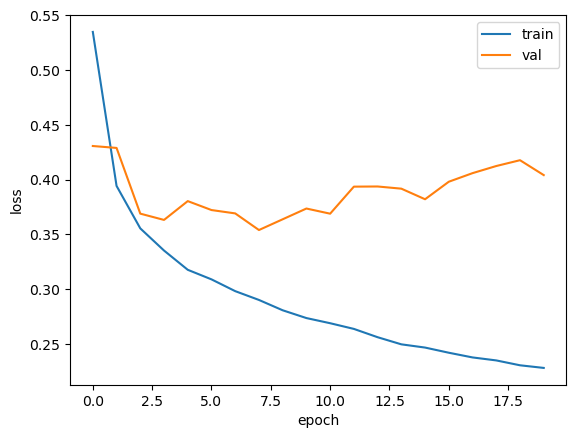

In [16]:
# '훈련 세트에 대한 손실값'과 '검증 세트에 대한 손실값'을 함께 시각화하여 비교
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

초기에 검증 손실이 감소하다가 *다시 상승*하기 시작한다.   
훈련 손실은 꾸준히 감소하기 때문에 에포크 값이 커질수록 전형적인 *과대적합 모델*이 만들어진다.   
*검증 손실이 상승하는 시점을 가능한 뒤로 늦추면* 검증 세트에 대한 손실이 줄어들 뿐 아니라 검증 세트에 대한 정확도도 증가할 것이다.   

신경망에 특화된 규제 방법을 사용할 수 있으나, 다음장에서.   
지금은 <u>optimizer를 사용</u>하여 과대적합을 완화시키는 방법을 알아보자.   
RMSprop, Adam을 많이 쓴다.

In [17]:
# Adam 옵티마이저 사용
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

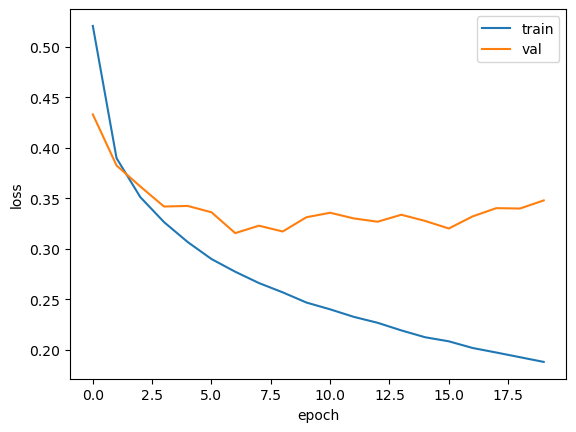

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

위의 결과보다 과대적합히 줄었다.   
10번째 에포크까지 전반적인 감소추세를 보이고 있다.

## 드롭아웃

<과대적합을 막기 위한 두번째 방식>   

훈련 과정에서 층에 있는 **일부 뉴런을 랜덤하게 꺼서**(뉴런의 출력을 0으로 만들어) 과대적합을 막는다.   
일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고, 모든 입력에 대해 주의를 기울여야 해서 과대적합을 막는다.

In [19]:
# 얼마나 많은 뉴런을 드롭할 지는 정해줘야 한다. 0.3이면, 30% 정도를 드롭아웃한다.
model = model_fn(keras.layers.Dropout(0.3))

model.summary()     # 뉴런의 갯수는 그대로. 단지 뉴런의 출력을 0으로 만들 뿐이다.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

주의) 훈련이 끝난 후 *평가나 예측을 수행할 때*는 드롭아웃을 적용하지 않아야 한다.
> **텐서플로와 케라스**는 평가와 예측 단계에서 드롭아웃을 적용하지 않는다.   
> 따라서 평가와 예측 단계에서도 **모델을 그대로 사용하면 된다.**

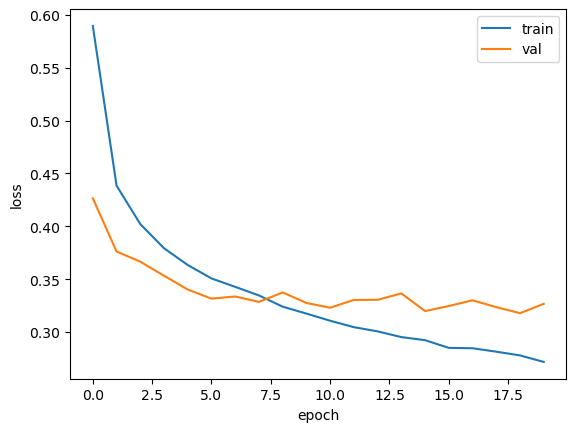

In [21]:
# 드롭아웃을 적용한 모델의 손실값 그래프

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 확실하게 줄어든 것을 확인할 수 있다.   
10번째 에포크 정도에서 검증 손실의 함수가 감소하는 것이 멈추지만, 크게 상승하지 않고 어느정도 유지된다.

다만, 에포크가 20번 이루어져 다소 과대적합 => 에포크를 줄이면 된다.

## 모델 저장과 복원

모델을 저장하면 이후 다시 사용할 수 있다.   
케라스 모델은 훈련된 모델의 파라미터를 저장하는 **save_weights()**,   
모델 구조와 모델 파라미터를 함께 저장하는 **save()** 메서드를 제공   

save_weights() 메서드는 기본적으로 텐서플로의 체크포인트 포맷으로 저장하지만,   
파일의 확장자를 **'.h5'로 작성하면 HDF5 포맷**으로 저장된다.   
save() 메서드는 기본적으로 텐서플로의 SavedModel 포맷으로 저장하지만,   
파일의 확장자를 **'.h5'로 작성하면 HDF5 포맷**으로 저장된다.

In [22]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

# 모델 생성 - 컴파일 - 학습 후

In [23]:
# 모델 파라미터 저장!
model.save_weights('model-weights.h5')

In [24]:
# 모델 구조와 모델 파라미터를 *함께* 저장!
model.save('model-whole.h5')

In [25]:
# .h5 확장자로 저장한 리스트 확인하기!
!ls -al *.h5

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
# 훈련하지 않은 새로운 모델 생성
model = model_fn(keras.layers.Dropout(0.3))

# 이 모델에 model-weights.h5 파일에서 훈련된 모델 파라미터(weigths)를 읽어서 사용
model.load_weights('model-weights.h5')

주의) load_weights() 메서드를 사용하려면 save_weights() 메서드로 저장했던 모델과 **정확히 같은 구조**를 가져야 한다.   
이렇게 활용하기에도 모델 생성에 **함수를 만들어 두는 것**이 유용하다.

In [27]:
model.predict(val_scaled).shape
# 저장된 파라미터가 새로운 모델에도 잘 들어와 있는 것을 확인할 수 있다.

375/375 [==============================] - 1s 2ms/step


(12000, 10)

In [28]:
# 정확도 계산
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))


375/375 [==============================] - 1s 1ms/step
0.8789166666666667


가장 큰 값(=어떤 레이블로 예측했는지)을 고르기 위해 numpy의 argmax() 함수 사용   
axis = -1 : 배열의 마지막 차원을 따라 최댓값을 고른다.   

argmax() 함수에서 반환한 레이블 인덱스(val_labels)와 정답(val_target)을 비교[val_labels == val_target]   
맞으면 1, 틀리면 0, 모든 값의 평균을 내면 **정확도** 도출 가능

In [29]:
# 모델 전체가 저장된 파일을 읽을 때는 keras.models.load_model()
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3391 - accuracy: 0.8789


[0.33906295895576477, 0.8789166808128357]

같은 모델을 저장하고 로드했기 때문에 정확도가 같은 것을 확인할 수 있다.   
- 파라미터만 해서 정확도 계산했을 때: 0.8798333333333334
- 모델 전체 돌리고 evaluate 했을 때: 0.8798333406448364

## 콜백

훈련과정 중간에 어떤 작업을 수행할 수 있게 하는 객체   
fit() 메서드의 callbacks 매개변수에 리스트로 전달   
ModelCheckpoint 콜백과 EarlyStopping 콜백이 있다.

1. ModelCheckpoint 콜백: 에포크마다 모델 저장   
save_best_only=True로 가장 낮은 검증 손실 점수를 만드는 모델을 저장할 수 있다.   

2. EarlyStopping(조기종료) 콜백: 과대적합이 시작되기 전에 훈련을 중지   
patience=n 매개변수에 n번 연속 검증 손실 점수가 낮아지지 않으면(=검증 점수가 향상되지 않으면) 훈련 중지   
restore_vest_weights=True로 가장 낮은 검증 손실 점수 모델로 다시 돌아가서, 모델 파라미터로 저장한다.   

위 두 콜백을 함께 사용하면 가장 낮은 검증 손실 모델을 파일에 저장하고,   
검증 손실이 일정기간 상승한다면 훈련을 중지할 수 있다.   
동시에, 최상의 파라미터를 저장한다.

In [30]:
# 1. ModelCheckpoint 콜백만 사용

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

# ModelCheckpoint 콜백 선언
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])                    # 리스트로 전달하는 것 주의!

In [31]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3240 - accuracy: 0.8867


[0.32396191358566284, 0.8867499828338623]

In [32]:
# 2. ModelCheckpoint 콜백과 EarlyStopping 콜백 함께 사용

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [33]:
print(early_stopping_cb.stopped_epoch)
# 몇 번째 에포크에서 훈련이 중지되었는지 early_stopping_cb.stopped_epoch 속성에서 확인할 수 있다.
# 에포크 횟수가 *0부터 시작*하기 때문에, 8은 9번째 에포크에서 훈련이 중지되었다는 것을 의미한다.
# patience를 2로 지정했으므로 *최상의 모델은 7번째 에포크*이다.
# 조기 종료 기법을 사용하면 안심하고 에포크 횟수를 크게 지정해도 괜찮다.

8


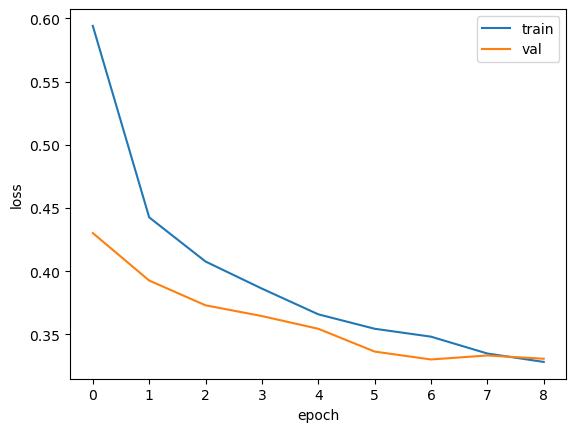

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [35]:
model.evaluate(val_scaled, val_target)
# 마지막으로 검증 세트를 이용한 성능 평가: 약 87%대의 정확도를 보인다.

375/375 [==============================] - 1s 1ms/step - loss: 0.3301 - accuracy: 0.8773


[0.3300988972187042, 0.8772500157356262]